# Hand gesture classification based on CNN



In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:

import pandas as pd # version 0.24.2
import numpy as np #version 1.16.4
import random
import matplotlib.pyplot as plt #matplotlib version 3.1.0
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns #version 0.9.0
from sklearn.model_selection import GridSearchCV
import math

In [43]:
Window_time= 100
Perc =25
window_length = math.floor(Window_time*2048/1000)
stride_length = math.floor(window_length*Perc/100)
print(window_length,stride_length)


204 51


## Import the Datasets

In [44]:
N_Subj = 1
N_Days = 1
N_rounds= 3
df= [[[0] * N_rounds]*N_Days]*N_Subj # dataframe for all rounds for all subjects for all days
print(df)
#making a header for dataframe
cl_names= []
for i in range(1,11):
    cl_names.append('CH'+str(i))
cl_names.append('class') #column dedicated to show which class of movement this sample belongs to
cl_names.append('move') #column dedicated to show which number of movement (out of 40 in each round) this sample belongs to
cl_names.append('window')
for i in range(0,N_Subj):
  for j in range(0,N_Days):   
   for k in range(0,N_rounds):
       df[i][j][k] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NEURO_PROJECT/FINAL DATA _ SUB1_DAY1/data/sbj'+str(i+1)+'_day'+str(j+1)+'_round'+str(k+1)+'_'+str(Window_time)+'_'+str(Perc)+'.csv')
       df[i][j][k].columns=cl_names
       print("Day"+str(j+1)+"_Subject"+str(i+1)+"_Round"+str(k+1))
       print("Round1",np.shape(df[i][j][k]))

[[[0, 0, 0]]]
Day1_Subject1_Round1
Round1 (1434120, 13)
Day1_Subject1_Round2
Round1 (1478796, 13)
Day1_Subject1_Round3
Round1 (1446360, 13)


In [45]:
#Day1_Subject1_Round1 shape
df[0][0][0].head(10)

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,class,move,window
0,-0.037422,-0.066970,-0.004722,-0.002298,0.009147,0.000264,0.030113,0.001229,-0.000046,0.024452,1,1,1
1,-0.027106,-0.069792,-0.003393,-0.001506,0.015246,0.010729,0.033083,0.002324,-0.017275,0.012365,1,1,1
2,-0.018335,-0.070210,-0.001637,-0.002423,0.015040,0.023082,0.037320,0.002860,-0.020864,0.027658,1,1,1
3,-0.012485,-0.066842,0.000101,-0.004762,0.013541,0.041201,0.037835,0.003687,-0.014293,0.056742,1,1,1
4,-0.004825,-0.060419,0.001824,-0.007347,0.013795,0.064046,0.031025,0.005208,-0.004321,0.062703,1,1,1
5,0.005364,-0.052430,0.003509,-0.008223,0.016031,0.087142,0.019538,0.006902,0.002390,0.029969,1,1,1
6,0.013969,-0.041837,0.003704,-0.006084,0.019951,0.097848,0.008052,0.007150,0.001886,-0.007631,1,1,1
7,0.018151,-0.027799,0.002206,-0.001399,0.023652,0.086413,-0.001507,0.006514,-0.002337,-0.010484,1,1,1
8,0.018671,-0.013399,0.001423,0.003602,0.024873,0.056382,-0.009276,0.007735,-0.002523,0.016994,1,1,1
9,0.016108,-0.001753,0.002477,0.005507,0.021791,0.019488,-0.013920,0.009651,0.004802,0.048708,1,1,1


## Data exploration

In [46]:
#Print class freq for each round of subject 1
# classes are from 1 to 8: 1 Flex, 2 Ext, 3 Sup, 4 Pron, 5 Open, 6 Pinch, 7 Lateral pinch, 8 Fist
def Class_freq(df):
  target_dist=df.groupby('class').size()/window_length  #number of windows for each type
  print(target_dist)
  print(type(target_dist))
print("rounds class distribution")
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
     print("Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
     Class_freq(df[i][j][k])

rounds class distribution
Class frequency for subject 1day 1round 1
class
1    880.0
2    883.0
3    876.0
4    879.0
5    903.0
6    878.0
7    862.0
8    869.0
dtype: float64
<class 'pandas.core.series.Series'>
Class frequency for subject 1day 1round 2
class
1    913.0
2    907.0
3    883.0
4    906.0
5    921.0
6    900.0
7    896.0
8    923.0
dtype: float64
<class 'pandas.core.series.Series'>
Class frequency for subject 1day 1round 3
class
1    907.0
2    908.0
3    898.0
4    737.0
5    917.0
6    902.0
7    903.0
8    918.0
dtype: float64
<class 'pandas.core.series.Series'>


## **Train and Test separation**

In [47]:
1#Train Test Seperation
df_train= [[[0] * N_rounds]*N_Days]*N_Subj # Train dataframe for all rounds for all subjects for all days (actually we use only 1 day and 1 subj at the time)
df_test = [[[0] * N_rounds]*N_Days]*N_Subj # Test dataframe for all rounds for all subjects for all days (actually we use only 1 day and 1 subj at the time )
def Train_Test_Sep(df):
  Trainset_class=[]
  Testset_class=[]
  for i in range(1,9):
    class_group = df.loc[df['class'] == i]
    Move_group=class_group.move.unique()
    Train1=df.loc[df['move'] ==Move_group[0]]
    Train2=df.loc[df['move'] ==Move_group[1]]
    Train3=df.loc[df['move'] ==Move_group[2]]
    Test1=df.loc[df['move'] ==Move_group[3]]
    if len(Move_group)==5:
      Test2=df.loc[df['move'] ==Move_group[4]]
      Testset_class.append(pd.concat((Test1,Test2)))
    else:
      Testset_class.append(Test1)
    Trainset_class.append(pd.concat((Train1,Train2,Train3)))
  Trainset=Trainset_class[0]
  Testset=Testset_class[0]

  for i in range(1,8):
    Trainset=np.vstack((Trainset,Trainset_class[i]))
    Testset=np.vstack((Testset,Testset_class[i]))
  df_Train = pd.DataFrame(data=Trainset, columns=cl_names)
  df_Test =  pd.DataFrame(data=Testset, columns=cl_names)
 
  return df_Train,df_Test

for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      df_train[i][j][k],df_test[i][j][k] = Train_Test_Sep(df[i][j][k])


In [48]:
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      print("Train Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
      Class_freq(df_train[i][j][k])

Train Class frequency for subject 1day 1round 1
class
1.0    526.0
2.0    537.0
3.0    531.0
4.0    535.0
5.0    557.0
6.0    539.0
7.0    518.0
8.0    521.0
dtype: float64
<class 'pandas.core.series.Series'>
Train Class frequency for subject 1day 1round 2
class
1.0    552.0
2.0    545.0
3.0    531.0
4.0    549.0
5.0    558.0
6.0    545.0
7.0    540.0
8.0    555.0
dtype: float64
<class 'pandas.core.series.Series'>
Train Class frequency for subject 1day 1round 3
class
1.0    545.0
2.0    549.0
3.0    547.0
4.0    548.0
5.0    560.0
6.0    533.0
7.0    542.0
8.0    560.0
dtype: float64
<class 'pandas.core.series.Series'>


In [49]:
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      print("Test Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
      Class_freq(df_test[i][j][k])

Test Class frequency for subject 1day 1round 1
class
1.0    354.0
2.0    346.0
3.0    345.0
4.0    344.0
5.0    346.0
6.0    339.0
7.0    344.0
8.0    348.0
dtype: float64
<class 'pandas.core.series.Series'>
Test Class frequency for subject 1day 1round 2
class
1.0    361.0
2.0    362.0
3.0    352.0
4.0    357.0
5.0    363.0
6.0    355.0
7.0    356.0
8.0    368.0
dtype: float64
<class 'pandas.core.series.Series'>
Test Class frequency for subject 1day 1round 3
class
1.0    362.0
2.0    359.0
3.0    351.0
4.0    189.0
5.0    357.0
6.0    369.0
7.0    361.0
8.0    358.0
dtype: float64
<class 'pandas.core.series.Series'>


## Create a 3D rappresentation

In [50]:
def _3D_representation(df):
  T=df.shape[0]
  p=int(T/window_length)
  print(p)
  df_3d = np.zeros((window_length, 13,p))
  df_3d[:,:,0]=df[0:window_length]  
  s=0
  i=0
  while s<T:    
    df_3d[:,:,i]=df[s:s+window_length]
    s=s+window_length
    i+=1
  return df_3d

In [51]:
df_Train_3d=[[[0] * N_rounds]*N_Days]*N_Subj
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      df_Train_3d[i][j][k]= _3D_representation(df_train[i][j][k])
print(df_Train_3d[0][0][0])

4264
4375
4384
[[[-3.7422e-02  2.6647e-02 -7.5255e-03 ...  4.8626e-02 -2.4397e-01
   -2.4453e-01]
  [-6.6970e-02  1.8986e-02 -6.8304e-02 ...  6.5525e-02 -7.0985e-02
   -1.2104e-02]
  [-4.7220e-03  4.4102e-03 -1.1789e-02 ...  2.3338e-02 -2.6937e-02
    1.5493e-02]
  ...
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  8.0000e+00  8.0000e+00
    8.0000e+00]
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  2.2000e+01  2.2000e+01
    2.2000e+01]
  [ 1.0000e+00  2.0000e+00  3.0000e+00 ...  3.8840e+03  3.8850e+03
    3.8860e+03]]

 [[-2.7106e-02  1.3596e-02  7.7599e-03 ...  4.4818e-02 -1.7503e-01
   -2.9992e-01]
  [-6.9792e-02  1.6916e-02 -6.4162e-02 ...  3.8007e-02 -7.1270e-02
   -3.1763e-02]
  [-3.3929e-03  6.4770e-03 -3.1845e-03 ...  1.7588e-02 -3.2901e-02
   -5.9464e-03]
  ...
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  8.0000e+00  8.0000e+00
    8.0000e+00]
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  2.2000e+01  2.2000e+01
    2.2000e+01]
  [ 1.0000e+00  2.0000e+00  3.0000e+00 ...  3.8840e+03  3.

In [52]:
Train_final_3d= df_Train_3d[0][0][0]
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      if i+j+k :
       Train_final_3d=np.concatenate([Train_final_3d, df_Train_3d[i][j][k]], -1)
Train_final_3d.shape     

(204, 13, 13023)

In [53]:
df_Test_3d=[[[0] * N_rounds]*N_Days]*N_Subj
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
       df_Test_3d[i][j][k]= _3D_representation(df_test[i][j][k])
print(df_Test_3d[0][0][0].shape)

2766
2874
2706
(204, 13, 2766)


In [54]:
Test_final_3d= df_Test_3d[0][0][0]
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      if i+j+k :
        Test_final_3d=np.concatenate([Test_final_3d, df_Test_3d[i][j][k]], -1)
Test_final_3d.shape

(204, 13, 8346)

## Shuffle the data

In [55]:
# ASK IF IT IS RIGHT

# SHUFFLE TRAIN DATA:

# Create an array of dimention = to the 3° dimention of df_Train_3d, i.e. the number of windows
ind_list = [i for i in range(0,Train_final_3d.shape[2])]  
# Shuffle it
np.random.shuffle(ind_list)
# Change the order of windows based on the shuffled index
df_Train_3d  = Train_final_3d[:,:,ind_list]

In [56]:
# SHUFFLE TEST DATA:

# Create an array of dimention = to the 3° dimention of df_Test_3d, i.e. the number of windows
ind_list_2 = [i for i in range(0,Test_final_3d.shape[2])]  
# Shuffle it
np.random.shuffle(ind_list_2)
# Change the order of windows based on the shuffled index
df_Test_3d  = Test_final_3d[:,:,ind_list_2]


In [57]:
print(df_Test_3d.shape)
print(df_Train_3d.shape)


(204, 13, 8346)
(204, 13, 13023)


## X and Y separation

In [58]:
# X_train is constituted by all the samples of all the windows for the 10 channels

X_train=df_Train_3d[:,0:10,:]
#print(X_train[:,:,10])
print(X_train.shape)
#print(X_train)


(204, 10, 13023)


In [59]:
# X_test is constituted by all the samples of all the windows for the 10 channels.

X_test=df_Test_3d[:,0:10,:]
#print(X_test[:,:,10])
print(X_test.shape)


(204, 10, 8346)


In [60]:
# Y_train is an array of dimention equal to the number of windows, that contains
# for each windows the corresponding class.

Y_train=df_Train_3d[1,-3,:]   
#print(Y_train[:])
print(Y_train.shape)


(13023,)


In [61]:
# Y_test is an array of dimention equal to the number of windows, that contains
# for each windows the corresponding class.

Y_test=df_Test_3d[1,-3,:]
#print(Y_test[:]);
print(Y_test.shape)


(8346,)


In [62]:
from keras.utils import to_categorical

Y_train_cat= to_categorical(Y_train-1)
print(Y_train[:10])
print(Y_train_cat[:10])

Y_test_cat= to_categorical(Y_test-1)
print(Y_test[:10])
print(Y_test_cat[:10])

Y_test_cat.shape

[4. 8. 5. 1. 7. 2. 8. 1. 5. 7.]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
[6. 2. 2. 5. 4. 7. 4. 2. 7. 3.]
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


(8346, 8)

In [63]:
print(X_train.shape)
X_train = np.swapaxes(X_train,0,2)
print(X_train.shape)
X_train = np.swapaxes(X_train,1,2)
print(X_train.shape)



(204, 10, 13023)
(13023, 10, 204)
(13023, 204, 10)


In [64]:
print(X_test.shape)
X_test = np.swapaxes(X_test,0,2)
print(X_test.shape)
X_test = np.swapaxes(X_test,1,2)
print(X_test.shape)

(204, 10, 8346)
(8346, 10, 204)
(8346, 204, 10)


In [65]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)
print(X_train.shape)
print(X_test.shape)

(13023, 204, 10, 1)
(8346, 204, 10, 1)


# CNN 

In [66]:
import tensorflow as tf
from tensorflow import keras

In [67]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [68]:
cnn_model = keras.Sequential([
                              
                              keras.layers.Conv2D(filters=32, kernel_size= (3,3), strides= (2,1),padding='same',  
                                                  activation='relu', input_shape=(window_length, 10,1)),  
                              keras.layers.MaxPooling2D(pool_size=(3,1)),  
                              
                              keras.layers.Dropout(0.5),
                              keras.layers.Conv2D(filters=64, kernel_size=(3,1),strides= (2,1),
                                                   padding='same', activation='relu'),
                              keras.layers.MaxPooling2D(pool_size=(2,1)),  
                              
                              keras.layers.Dropout(0.5),
                              keras.layers.Conv2D(filters=32, kernel_size= (2,1),strides= (1,1),
                                                  padding='same', activation='relu'),
                              keras.layers.MaxPooling2D(pool_size=(2,1)),  
                                                                             
                              keras.layers.Flatten(),

                              keras.layers.Dense(64, activation=tf.nn.relu),
                                               
                              keras.layers.Dense(8, activation=tf.nn.softmax) 

                              ])

In [69]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 10, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 10, 64)        6208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 10, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 10, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 10, 32)         4

# TRAIN

In [70]:
cnn_model.compile(
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )

hist = cnn_model.fit(X_train, Y_train_cat, epochs=30)

Epoch 1/30
407/407 [==============================] - 9s 4ms/step - loss: 0.7763 - accuracy: 0.7009
Epoch 2/30
407/407 [==============================] - 1s 4ms/step - loss: 0.1805 - accuracy: 0.9390
Epoch 3/30
407/407 [==============================] - 2s 4ms/step - loss: 0.1314 - accuracy: 0.9551
Epoch 4/30
407/407 [==============================] - 1s 3ms/step - loss: 0.1055 - accuracy: 0.9698
Epoch 5/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0887 - accuracy: 0.9707
Epoch 6/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0904 - accuracy: 0.9674
Epoch 7/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0694 - accuracy: 0.9743
Epoch 8/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0658 - accuracy: 0.9788
Epoch 9/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0662 - accuracy: 0.9777
Epoch 10/30
407/407 [==============================] - 1s 3ms/step - loss: 0.0551 - accuracy: 0.9819

# TEST

In [71]:
import time
t0= time.clock()
y_pred = cnn_model.predict(X_test)
t1 = time.clock() - t0
print("Total time : %f [s]\nTime for a window : %f [s]" %(t1,t1/X_test.shape[0]))

Total time : 0.600972 [s]
Time for a window : 0.000072 [s]


In [72]:
y_pred = np.argmax(y_pred, axis=1)
y_pred_cat = to_categorical(y_pred)

In [73]:
test_loss, test_acc = cnn_model.evaluate(X_test, Y_test_cat)
print("Test accuracy:", test_acc)

261/261 [==============================] - 1s 2ms/step - loss: 0.0819 - accuracy: 0.9829
Test accuracy: 0.9828660488128662


In [74]:
acc =  metrics.accuracy_score(Y_test_cat,y_pred_cat)
print("Test accuracy:",acc)

Test accuracy: 0.9828660436137072


0.9828660436137072


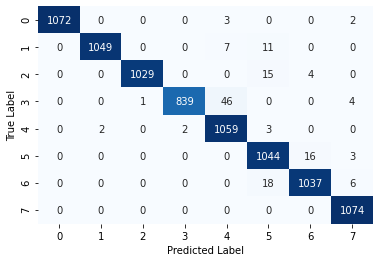

In [75]:
sns.heatmap(confusion_matrix(Y_test-1, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(acc)


In [76]:
print("Window Size [ms]: %.0f " % (Window_time))
print(f"Stride: {Perc} % \n")
print("CNN  accuracy - TRAIN: %f " % (hist.history['accuracy'][-1] ))
print("CNN  accuracy - TEST: %f " % (test_acc))
print("Total time : %f [s]\nTime for a window : %f [s]" %(t1,t1/X_test.shape[0]))

Window Size [ms]: 100 
Stride: 25 % 

CNN  accuracy - TRAIN: 0.991246 
CNN  accuracy - TEST: 0.982866 
Total time : 0.600972 [s]
Time for a window : 0.000072 [s]


In [77]:
((t1/X_test.shape[0])*1000)+Window_time


100.07200718907261

In [78]:
parameters = [Window_time, Perc, test_acc, ((t1/X_test.shape[0])*1000)+Window_time];
import csv
with open('/content/drive/MyDrive/NEURO_PROJECT/ACCURACY_TIME_DATA/CNN/parameters_CNN_day3.csv', mode='a') as parameter_file:
  parameter_writer = csv.writer(parameter_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  parameter_writer.writerow(parameters)